# Step 2 — Exploratory Data Analysis (EDA)

This notebook explores the cleaned Telco churn dataset and produces visualizations to surface initial insights for feature engineering and modeling.

Outputs:
- Distribution plots for numerical features (MonthlyCharges, tenure)
- Bar charts for categorical features (InternetService, Contract, PaymentMethod)
- Stacked bar chart showing churn rate by Contract type
- Correlation matrix for numeric features

The notebook saves figures to `reports/figures/` and a small CSV summary to `reports/eda_summary.csv`.


Loaded cleaned data: ../data/cleaned_telco_churn.csv
Shape: (7032, 47)
Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
                 count         mean          std    min       25%       50%  \
SeniorCitizen   7032.0     0.162400     0.368844   0.00    0.0000     0.000   
tenure          7032.0    32.421786    24.545260   1.00    9.0000    29.000   
MonthlyCharges  7032.0    64.798208    30.085974  18.25   35.5875    70.350   
TotalCharges    7032.0  2283.300441  2266.771362  18.80  401.4500  1397.475   

                      75%      max  
SeniorCitizen      0.0000     1.00  
tenure            55.0000    72.00  
MonthlyCharges    89.8625   118.75  
TotalCharges    3794.7375  8684.80  
Saved reports/figures/dist_MonthlyCharges.png
Saved reports/figures/dist_MonthlyCharges.png


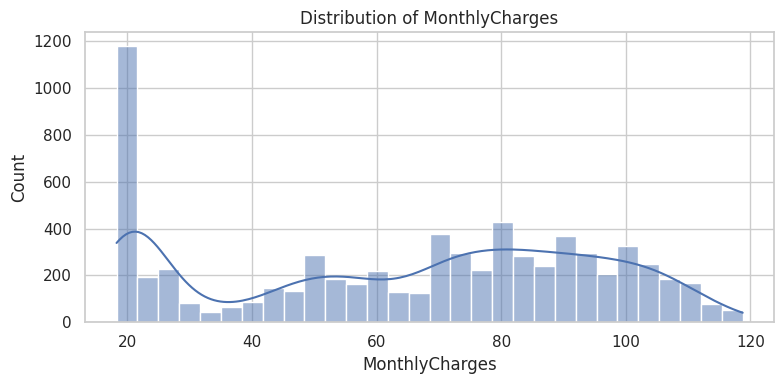

Saved reports/figures/dist_TotalCharges.png


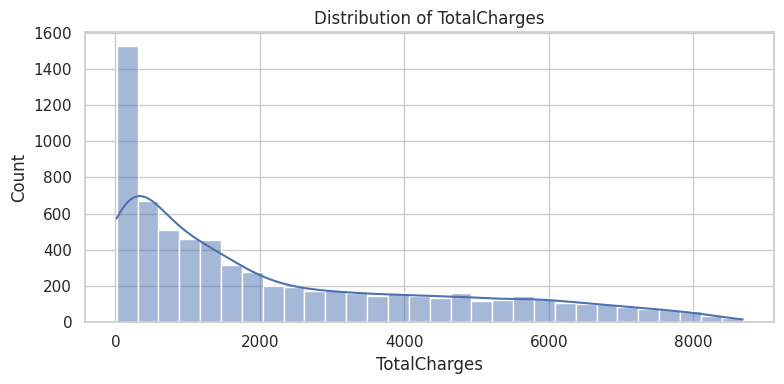

Saved reports/figures/dist_tenure.png


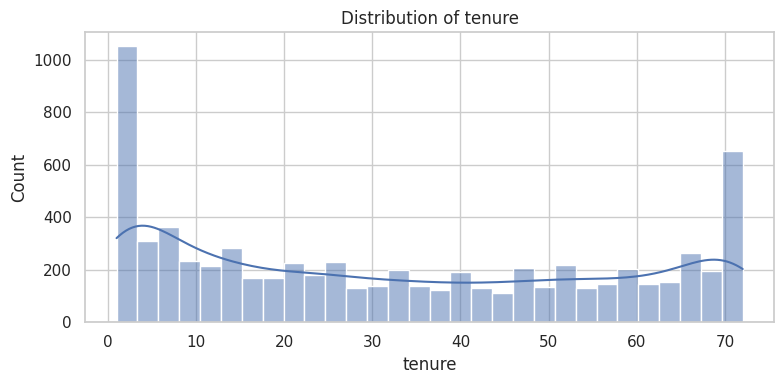

Saved reports/figures/bar_InternetService.png


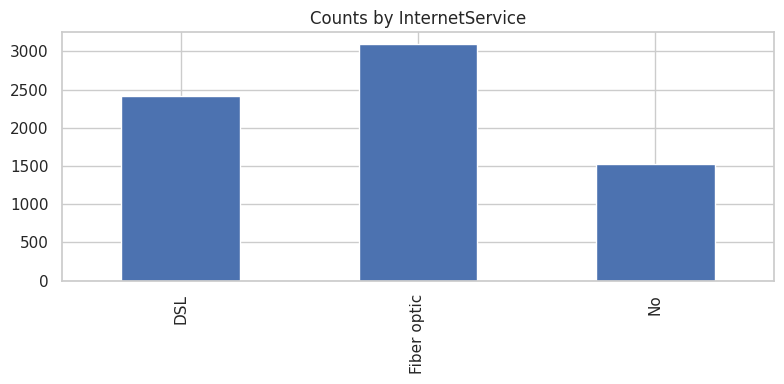

Saved reports/figures/bar_Contract.png


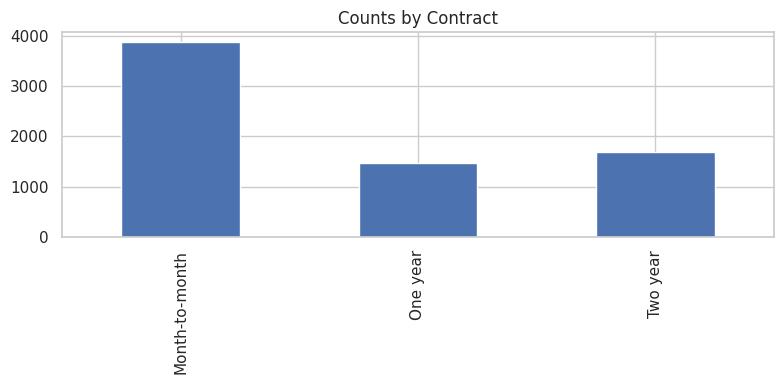

Saved reports/figures/bar_PaymentMethod.png


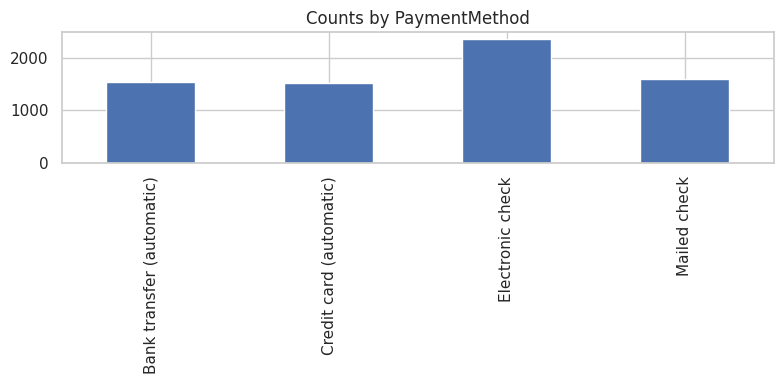

                churn_rate  count
Contract_recon                   
Month-to-month    0.427097   3875
One year          0.112772   1472
Two year          0.028487   1685
Saved reports/figures/stacked_churn_by_Contract_recon.png


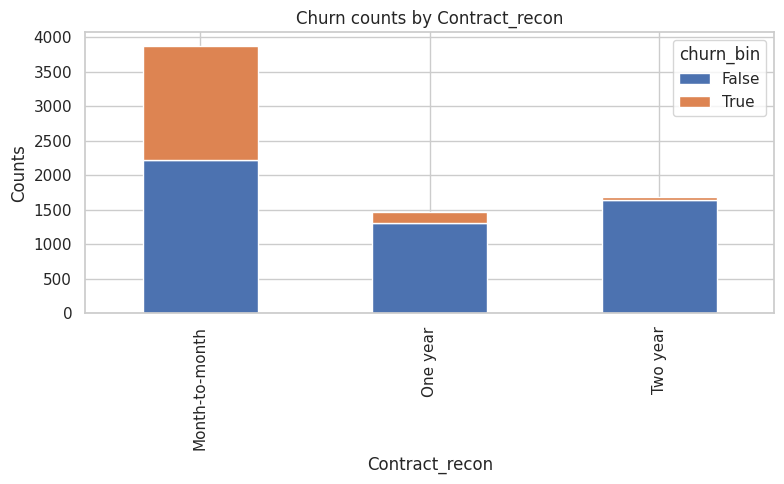

Saved reports/figures/corr_numeric.png


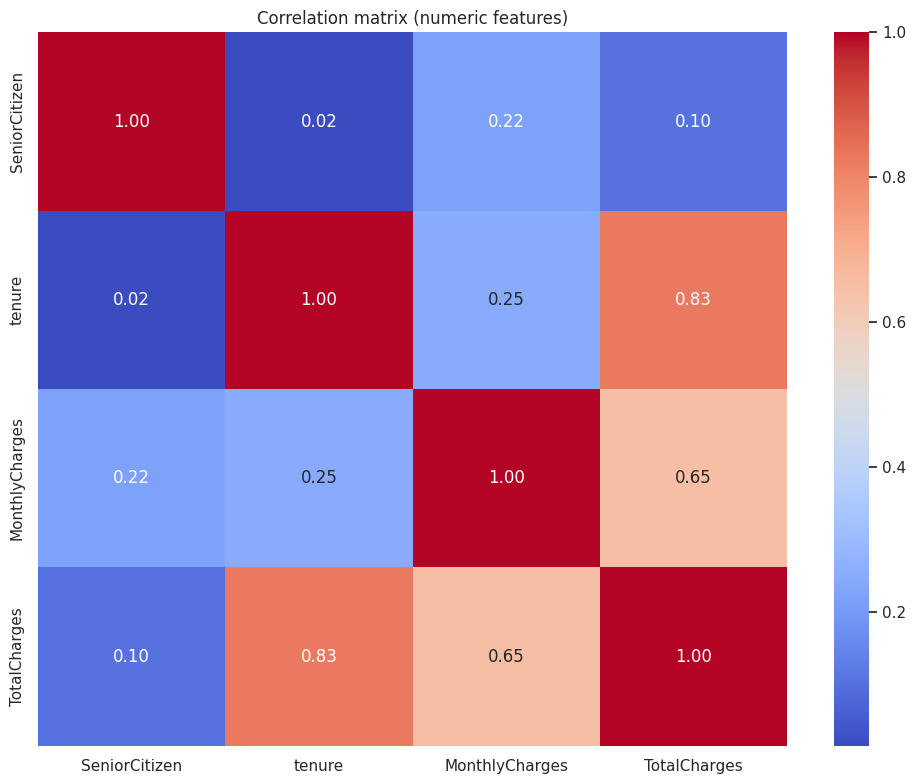

Saved EDA summary to reports/eda_summary.csv
Notebook complete — review figures in reports/figures


In [ ]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
pd.set_option('display.max_columns', 100)

OUT_DIR = Path('../outputs/figures')
OUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = Path('../outputs')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Load cleaned dataset produced in Step 1
clean_path = Path('..') / 'data' / 'cleaned_telco_churn.csv'
if not clean_path.exists():
    raise FileNotFoundError(f'Cleaned data not found at {clean_path}. Run notebooks/01-data-cleaning.ipynb first.')
df = pd.read_csv(clean_path)
print('Loaded cleaned data:', clean_path)
print('Shape:', df.shape)

df.head()

# Basic numeric summaries
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)
print(df[numeric_cols].describe().T)

# Histograms for key numerical features
num_feats = ['MonthlyCharges', 'TotalCharges', 'tenure']
for col in num_feats:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        out = OUT_DIR / f'dist_{col}.png'
        plt.savefig(out)
        print('Saved', out)
        plt.show()

# Bar charts for categorical features
cat_features = ['InternetService', 'Contract', 'PaymentMethod']
for col in cat_features:
    if col in df.columns or any(c.startswith(col + '_') for c in df.columns):
        plt.figure(figsize=(8,4))
        if col in df.columns:
            counts = df[col].value_counts().sort_index()
        else:
            ocols = [c for c in df.columns if c.startswith(col + '_')]
            counts = df[ocols].sum().rename(index=lambda x: x.replace(col + '_', ''))
        counts.plot(kind='bar')
        plt.title(f'Counts by {col}')
        plt.tight_layout()
        out = OUT_DIR / f'bar_{col}.png'
        plt.savefig(out)
        print('Saved', out)
        plt.show()
    else:
        print('Feature', col, 'not found in dataframe (maybe encoded).')

# Resolve churn column name and prepare grouped churn rates
if 'Churn' in df.columns:
    churn_series = df['Churn']
    if churn_series.dtype == object:
        churn_series = churn_series.map({'No':0,'Yes':1})
    df['churn_bin'] = churn_series
else:
    ch_cols = [c for c in df.columns if c.startswith('Churn_')]
    if ch_cols:
        yes_col = next((c for c in ch_cols if c.endswith('_Yes') or c.endswith('Yes')), ch_cols[0])
        df['churn_bin'] = df[yes_col]
    else:
        raise KeyError('Churn column not found; cannot compute churn rates')

# Group churn rates by Contract
if 'Contract' in df.columns:
    group_col = 'Contract'
else:
    ccols = [c for c in df.columns if c.startswith('Contract_')]
    if ccols:
        df['Contract_recon'] = df[ccols].idxmax(axis=1).str.replace('Contract_','')
        group_col = 'Contract_recon'
    else:
        raise KeyError('Contract information not found')

gr = df.groupby(group_col)['churn_bin'].agg(['mean','count']).rename(columns={'mean':'churn_rate'})
print(gr)

stacked = df.groupby(group_col)['churn_bin'].value_counts(normalize=False).unstack(fill_value=0)
stacked.plot(kind='bar', stacked=True, figsize=(8,5))
plt.ylabel('Counts')
plt.title('Churn counts by ' + group_col)
out = OUT_DIR / f'stacked_churn_by_{group_col}.png'
plt.tight_layout()
plt.savefig(out)
print('Saved', out)
plt.show()

# Correlation matrix for numeric features
num = df.select_dtypes(include=[np.number]).copy()
plt.figure(figsize=(10,8))
corr = num.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (numeric features)')
out = OUT_DIR / 'corr_numeric.png'
plt.tight_layout()
plt.savefig(out)
print('Saved', out)
plt.show()

# Save a small summary CSV with group churn rates for quick reference
summary_path = REPORTS_DIR / 'eda_summary.csv'
gr.to_csv(summary_path)
print('Saved EDA summary to', summary_path)
print('Notebook complete — review figures in ../outputs/figures')


## Hypotheses found so far

- Customers on month-to-month contracts, with Fiber optic internet and paying by Electronic check appear more likely to churn (to be validated with modeling).
- Higher monthly charges and lower tenure correlate with higher churn probability.

Next: feature engineering and baseline models in Step 3.
